<a href="https://colab.research.google.com/github/deagwon97/dacon-satellite-precipitation/blob/master/model/ResNet_rot_transpose_cutmix_tpu_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# < 목차 >

    I.    Library import  
    II.   Data Load  
    III.  Preprocess  
    IV.   connect TPU  
    V.    Make model  
    VI.   Make data generator
        1. augmentation - rotation, transpose
        2. augmentation - cutmix
        3. get dataset
        4. cutmix 적용결과 시각화
    VII.  Socre function
    VIII. Train
    IX.   Train Result
    X.    submission

# I. Library import

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats
import tensorflow as tf, tensorflow.keras.backend as K
import math
import os
import tensorflow_datasets as tfds
from sklearn.model_selection import KFold
import pickle

warnings.filterwarnings("ignore")

# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)


AUTOTUNE = tf.data.experimental.AUTOTUNE
AUTO = tf.data.experimental.AUTOTUNE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


 위성관측 데이터 활용 강수량 산출 AI 경진대회에서 사용했던 모델링 코드를 공유합니다. (Public Score : 1.5716695482)

# II. Data Load

 여러개로 나누어져 있었던 파일을 하나의 numpy array로 만들어 Google Drive에 올리고, colab에서 불러와 사용였습니다. (하나의 numpy array로 만드는 코드는 시각화 글을 참고해 주세요)

```
train = np.load('//<구글 드라이브 경로>/train.npy')
```  
 위와 같이 한번에 train을 바로 불러올 수도 있지만 
```
!cp '//<구글 드라이브 경로>/train.npy' train.npy
train = np.load('train.npy')
```
이렇게 파일을 colab의 디스크로 옮긴 후 load하였습니다.

 
 구글 드라이브는 하루 최대 다운로드 용량에 제한이 있습니다. 모델링 혹은 파일을 처리하다 보면 RAM 용량을 초과하여 세션이 자주 다운되는데요. 이때, 반복해서 구글 드라이브의 파일을 다시 로드하면 input/output error가 발생하면서 더 이상 파일을 로드할 수 없게 됩니다. (하루 쉬어야합니다.)
 
  이에 대한 해결책으로 드라이브의 파일을 colab의 디스크에 옮겨서 사용하는 방법을 선택했어요, colab의 디스크는 런타임이 초기화 되어도 파일이 계속 유지되어 드라이브에서 불러오지 않아도 쓸 수 있습니다.  


다른 방법을 알고계신분들은 댓글로 알려주시면 감사하겠습니다 :)  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp '//content/drive/My Drive/kaggledrive/satellite/train.npy' train.npy
train = np.load('train.npy')

In [ ]:
train.shape
# >>>(76345, 40, 40, 15)

# III. Preprocess

한 샘플내부에 강수량 총합이 50 미만인 데이터는 제거하고 훈련에 사용하였습니다.

In [ ]:
# land_type 사이즈 조절
def preprocess(data):
    land_type_data = data[:,:,:,9]
    data[:,:,:,9] = np.where(land_type_data//100 == 2, 0.7,
                             np.where(land_type_data//100 == 3, 0.3,
                                      land_type_data//100))
    return data

# 강수량 합 50미만 제거
is_valid = (train[:,:,:,-1].reshape(-1, 1600) < 0).sum(axis=1) == 0
is_valid = is_valid & ((train[:,:,:,-1].reshape(-1, 1600) >= 0.1).sum(axis=1) >= 50)
train = train[is_valid]  # (-1, 40, 40, 15)
train = preprocess(train)
train.shape
# >>>(30662, 40, 40, 15)
# 모든 데이터를 전부 사용하면 76345개 중 30662개의 sample이 선택됩니다.

# IV. connect TPU

In [7]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.93.110.66:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.93.110.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.93.110.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# V. Make model

GoldBar님의 ResNet 기반 모델을 사용하였습니다.

In [6]:
def create_model():
    inputs=Input((40, 40, 10))
    
    conv0=Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(inputs)
    conv0=Dropout(0.5)(conv0)
    
    bn=BatchNormalization()(conv0)
    conv=Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    conv=Dropout(0.5)(conv)
    concat=concatenate([conv0, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    conv=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
    conv=Dropout(0.5)(conv)
    concat=concatenate([concat, conv], axis=3)

    for i in range(5):
        bn=BatchNormalization()(concat)
        conv=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        conv=Dropout(0.5)(conv)
        concat=concatenate([concat, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    outputs=Conv2D(1, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    model=Model(inputs=inputs, outputs=outputs)
    
    return model

# VI. Make data generator

## 1.augmentation - rotation, transpose

In [8]:
# aumentation code는 다음 글을 참고하여 만들었습니다.
# 제 나름 의미를 생각하면서 주석을 작성하였습니다.(잘못된 내용은 댓글로 알려주시면 감사하겠습니다.)
# https://www.kaggle.com/tuckerarrants/kfold-efficientnet-augmentations-s/code
# https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu

def get_mat():
    # returns 3x3 transformmatrix which transforms indicies
    # CONVERT degree를 radian으로 변환
    rotation = tf.random.uniform([1], minval=0, maxval=4, dtype=tf.dtypes.int32, seed=None, name=None) / 2 * math.pi

    # ROTATION MATRIX
    rotation = tf.random.uniform([1], minval=0, maxval=4, dtype=tf.dtypes.int32, seed=None, name=None)
    rotation = tf.cast(rotation, 'float32')
    rotation = rotation * math.pi / 2.
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # TRANSPOSE MATRIX 
    de_t = tf.random.uniform([1], minval = 0, maxval = 2, dtype = tf.int32)
    de_t = tf.cast(de_t, 'float32')
    forty = tf.constant([40],dtype='float32')
    transpose_matrix = tf.reshape( tf.concat([1 - de_t, -de_t, de_t, -de_t, 1 - de_t, de_t, zero, zero, one], axis = 0),[3,3])   
    return K.dot(rotation_matrix, transpose_matrix)

def transform(train_x,train_y):
    # rotation과 transpose를 적용
    DIM = 40
    # GET TRANSFORMATION MATRIX
    m = get_mat()
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM)
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM])
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    train_x_img = tf.gather_nd(train_x,tf.transpose(idx3))
    train_y_img = tf.gather_nd(train_y,tf.transpose(idx3))

    return tf.reshape(train_x_img,[DIM,DIM,10]),tf.reshape(train_y_img,[DIM,DIM,1])

## 2.augmentation - cutmix

In [9]:
AUTO = tf.data.experimental.AUTOTUNE
# Configuration
IMAGE_SIZE = [40, 40]
SEED = 777
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
AUG_BATCH = BATCH_SIZE
FIRST_FOLD_ONLY = False

def cutmix(image, label, PROBABILITY = 1.0):
    # input image - 하나의 [dim, dim, ch]이 아닌 [n, dim, dim, ch] 크기의 batch 이다.
    # output - cutmix가 적용된 batch 이다.
    # 일반적인 문제에서는image에서만 cutmix를 적용하지만, 강수량 대회에서는 label 또한 cutmix를 적용해야한다.
    DIM = 40
    imgs = []
    labs = []
    PROBABILITY = 1.0

    for j in range(AUG_BATCH):
        # PROBABILITY에 따라서 cutmix를 적용한다.(PROBABILITY =1 이므로 모든 샘플에 적용)
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0, AUG_BATCH),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P

        ya = tf.math.maximum(0,y-WIDTH//2) 
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)

        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)

        # MAKE CUTMIX LABEL
        one = label[j,ya:yb,0:xa,:]
        two = label[k,ya:yb,xa:xb,:]
        three = label[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        lab = tf.concat([label[j,0:ya,:,:], middle, label[j,yb:DIM,:,:]],axis=0)
        labs.append(lab)

    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,10))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,DIM,DIM,1))
    return image2,label2

## 3.get dataset

In [23]:
def get_training_dataset(dataset, do_aug=True):
    # datset을 반복
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    # transform을 적용(rotation, transpose)
    dataset = dataset.map(transform, num_parallel_calls=AUTO)

    # cutmix를 위한 AUG_BATCH 단위로 자르기
    dataset = dataset.batch(AUG_BATCH)
    # cutmix를 적용
    dataset = dataset.map(cutmix, num_parallel_calls=AUTO) # note we put AFTER batching

    # 다시 합치기
    dataset = dataset.unbatch()

    # suffle
    dataset = dataset.shuffle(2048)
    # BATCH_SIZE 단위로 자르기
    dataset = dataset.batch(BATCH_SIZE)
    # 다음 batch 연산에 필요한 data들을 미리 가져오기
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(dataset,batch_size = None):
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

## 4.cutmix 적용결과 시각화

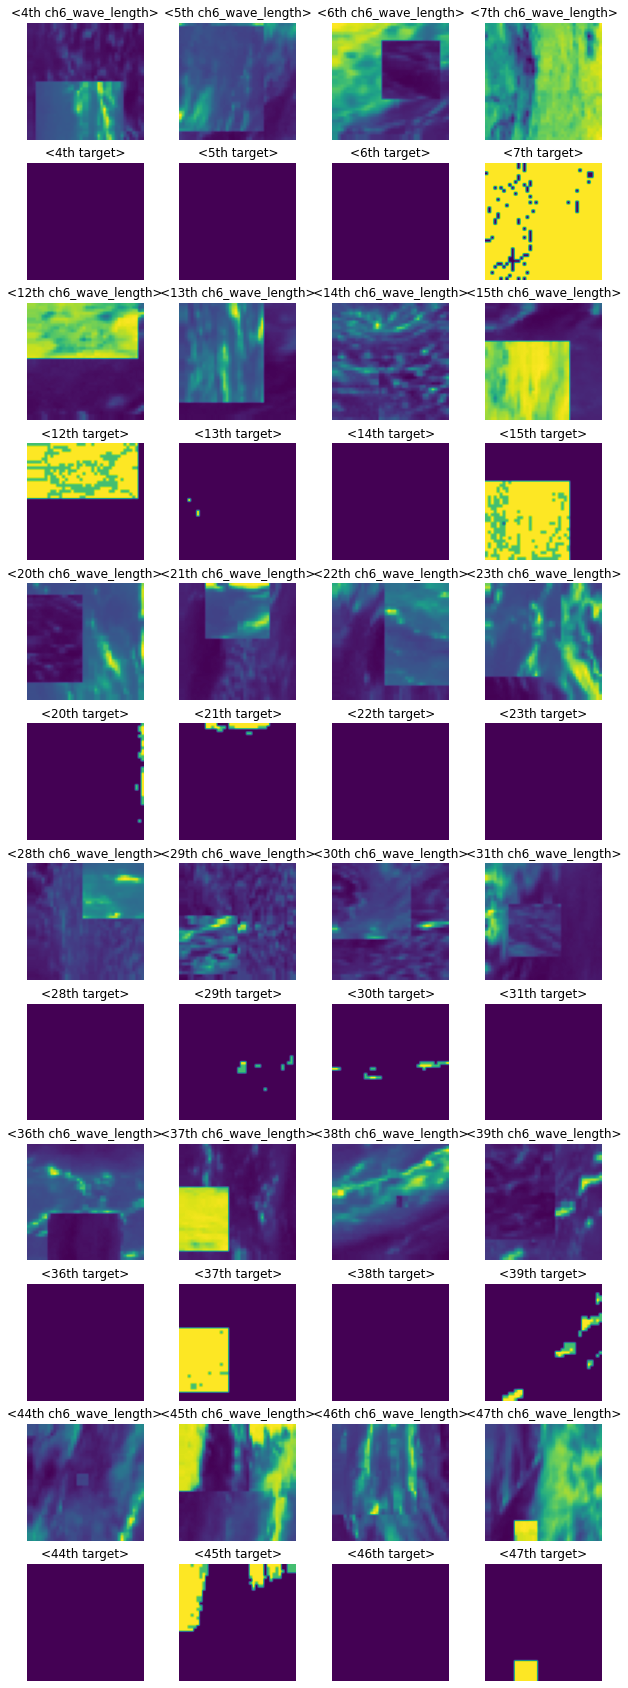

In [24]:
x_train =train[100:200,:,:,:10]
y_train = train[100:200,:,:,-1].reshape(-1,40,40,1)

row = 6; col = 4;
all_elements = tf.data.Dataset.from_tensor_slices((x_train, y_train))
all_elements = get_training_dataset(all_elements)

for (img,label) in all_elements:
    fig, axes = plt.subplots(nrows= row*2, ncols= col)
    fig.set_size_inches(10.5, 30.5)
    for j in range(2*row*col):
        axes[2 * (j//(2 * col))    , j % (col)].imshow(img[j,:,:,6])
        axes[2 * (j//(2 * col))    , j % (col)].set_title(f'<{j}th ch6_wave_length>')
        axes[2 * (j//(2 * col))    , j % (col)].axis('off')

        axes[2 * (j//(2 * col)) + 1, j % (col)].imshow(img[j,:,:,-1])
        axes[2 * (j//(2 * col)) + 1, j % (col)].set_title(f'<{j}th target>')
        axes[2 * (j//(2 * col)) + 1, j % (col)].axis('off')
    plt.show()
    break

# VII. Score function

 tpu를 사용하여 훈련시 python 문법으로 만든 함수를 쓸 경우, error가 발생하였습니다. tensorflow 문법을 통해서 score 함수를 만들어 사용했더니 해결되었습니다.

In [13]:
### tensor로 score matric 구현
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def custom_mae(y_true, y_pred):
    y_error = y_pred - y_true
    bool_idx = tf.less_equal(0.1,y_true)
    len_mae = tf.reduce_sum(tf.cast(bool_idx, tf.float32))
    socre = tf.math.abs(y_error)
    mae = tf.keras.backend.switch(bool_idx, socre, 0)
    return tf.divide(tf.math.reduce_sum(mae), len_mae)

def custum_f1score(y_true, y_pred):
    bool_true = tf.less_equal(0.1,y_true)
    y_true = tf.where(bool_true, 1., 0.)
    bool_pred = tf.less_equal(0.1,y_pred)
    y_pred = tf.where(bool_pred, 1., 0.)
    return(f1_metric(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    f1_score = custum_f1score(y_true, y_pred) + 1e-07
    return tf.divide(custom_mae(y_true, y_pred), f1_score)

# VIII. Train

In [ ]:
# n_split을 5로 설정하여 kfold 학습.
k_fold = KFold(n_splits=5, shuffle=True, random_state=7777)

# fold가 진행 될 때 마다 model_number를 +1
model_number = 0
for train_idx, val_idx in k_fold.split(train):
    print(f'Fold{model_number + 1}')
    #x_val, y_val = train[val_idx, :, :, :10], train[val_idx, :, :, -1]
    models = []
    ### TPU 할당 및 초기화-------------------------------------------------------
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
    ### 모델 생성 및 compile-----------------------------------------------------
    with strategy.scope():
        model = create_model()
        model.compile(optimizer = 'adam',loss = 'mae',
        metrics=[maeOverFscore, custum_f1score, custom_mae]
        )
    ### 콜백 생성----------------------------------------------------------------
    callbacks_list = [
        tf.keras.callbacks.ReduceLROnPlateau(# val_loss가 9 epoch 동안 감소하지 않으면 lr을 0.8배
            monitor='val_loss',
            patience=9,
            factor=0.8
        ),

        tf.keras.callbacks.ModelCheckpoint(
            filepath = f'<경로>/restnet_model_{model_number}.h5',
            monitor='val_maeOverFscore',
            save_best_only=True # val_maeOverFscore를 기준으로 한 epoch이 끝날 때 마다 가장 높은 성능의 모델을 주어진 경로로 저장
        )
    ]
    # batch_dataset 만들기-------------------------------------------------------
    batch_size = 128
    #train_batch
    train_dataset = tf.data.Dataset.from_tensor_slices((train[train_idx, :, :, :10],
                                                        train[train_idx, :, :, -1]))
    train_dataset = get_training_dataset(train_dataset)
    #validation_batch
    validation_dataset = tf.data.Dataset.from_tensor_slices((train[val_idx, :, :, :10],
                                        train[val_idx, :, :, -1]))
    
    validation_dataset = get_validation_dataset(validation_dataset,batch_size=batch_size)

    ### model.fit----------------------------------------------------------------
    history = model.fit(train_dataset, epochs=500,
                        # batch size에 따라서 한 epoch당 step수가 달라짐
            steps_per_epoch = len(train[train_idx, :, :, :10]) // batch_size,
            validation_data=validation_dataset,
            callbacks=callbacks_list
            )
    # 한 폴드가 끝날 때 마다 모델의 학습 결과를 구글 드라이브에 저장
    with open(f'<구글 드라이브 경로>/histtory_{model_number}', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)

    model_number = model_number + 1
    ### model append ------------------------------------------------------------

Fold1


INFO:tensorflow:Initializing the TPU system: grpc://10.103.175.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.103.175.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/500
191/191 [==============================] - 27s 139ms/step - maeOverFscore: 2.5960 - loss: 0.3073 - custom_mae: 1.6087 - custum_f1score: 0.6508 - val_maeOverFscore: 150287.5625 - val_loss: 0.3445 - val_custom_mae: 2.1737 - val_custum_f1score: 0.1236 - lr: 0.0010
Epoch 2/500
191/191 [==============================] - 15s 76ms/step - maeOverFscore: 2.1512 - loss: 0.2486 - custom_mae: 1.5034 - custum_f1score: 0.6989 - val_maeOverFscore: 5.5001 - val_loss: 0.3149 - val_custom_mae: 1.9914 - val_custum_f1score: 0.3820 - lr: 0.0010
Epoch 3/500
191/191 [==============================] - 15s 77ms/step - maeOverFscore: 2.0370 - loss: 0.2399 - custom_mae: 1.4593 - custum_f1score: 0.7154 - val_maeOverFscore: 2.6276 - val_loss: 0.2611 - val_custom_mae: 1.6471 - val_custum_f1score: 0.6326 - lr: 0.0010
Epoch 4/500
191/191 [==============================] - 14s 76ms/step - maeOverFscore: 1.9859 - loss: 0.2368 - custom_mae: 1.4369 - custum_f1score: 0.7232 - val_maeOverFscore: 2.0732 - val_lo

INFO:tensorflow:Initializing the TPU system: grpc://10.103.175.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.103.175.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/500
191/191 [==============================] - 24s 125ms/step - maeOverFscore: 2.7249 - loss: 0.3113 - custom_mae: 1.6510 - custum_f1score: 0.6391 - val_maeOverFscore: 234830.8594 - val_loss: 0.3383 - val_custom_mae: 2.1067 - val_custum_f1score: 0.0796 - lr: 0.0010
Epoch 2/500
191/191 [==============================] - 14s 75ms/step - maeOverFscore: 2.1217 - loss: 0.2486 - custom_mae: 1.5004 - custum_f1score: 0.7067 - val_maeOverFscore: 4.7652 - val_loss: 0.3058 - val_custom_mae: 1.9089 - val_custum_f1score: 0.4146 - lr: 0.0010
Epoch 3/500
191/191 [==============================] - 14s 75ms/step - maeOverFscore: 2.0405 - loss: 0.2429 - custom_mae: 1.4682 - custum_f1score: 0.7190 - val_maeOverFscore: 2.5310 - val_loss: 0.2578 - val_custom_mae: 1.6028 - val_custum_f1score: 0.6347 - lr: 0.0010
Epoch 4/500
191/191 [==============================] - 14s 76ms/step - maeOverFscore: 1.9521 - loss: 0.2373 - custom_mae: 1.4345 - custum_f1score: 0.7340 - val_maeOverFscore: 2.0674 - val_lo

INFO:tensorflow:Initializing the TPU system: grpc://10.103.175.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.103.175.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/500
191/191 [==============================] - 24s 128ms/step - maeOverFscore: 2.6000 - loss: 0.2998 - custom_mae: 1.6271 - custum_f1score: 0.6535 - val_maeOverFscore: 1452817.0000 - val_loss: 0.3511 - val_custom_mae: 2.1670 - val_custum_f1score: 0.0140 - lr: 0.0010
Epoch 2/500
191/191 [==============================] - 15s 76ms/step - maeOverFscore: 2.1009 - loss: 0.2457 - custom_mae: 1.4924 - custum_f1score: 0.7103 - val_maeOverFscore: 7.3567 - val_loss: 0.3288 - val_custom_mae: 2.0338 - val_custum_f1score: 0.3026 - lr: 0.0010
Epoch 3/500
191/191 [==============================] - 14s 76ms/step - maeOverFscore: 2.0191 - loss: 0.2404 - custom_mae: 1.4642 - custum_f1score: 0.7243 - val_maeOverFscore: 2.4401 - val_loss: 0.2633 - val_custom_mae: 1.6234 - val_custum_f1score: 0.6663 - lr: 0.0010
Epoch 4/500
191/191 [==============================] - 15s 76ms/step - maeOverFscore: 1.9968 - loss: 0.2389 - custom_mae: 1.4521 - custum_f1score: 0.7272 - val_maeOverFscore: 2.2886 - val_l

INFO:tensorflow:Initializing the TPU system: grpc://10.103.175.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.103.175.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/500
191/191 [==============================] - 25s 129ms/step - maeOverFscore: 2.8063 - loss: 0.3129 - custom_mae: 1.6413 - custum_f1score: 0.6312 - val_maeOverFscore: 137232.9531 - val_loss: 0.3579 - val_custom_mae: 2.1753 - val_custum_f1score: 0.1003 - lr: 0.0010
Epoch 2/500
191/191 [==============================] - 15s 76ms/step - maeOverFscore: 2.1292 - loss: 0.2451 - custom_mae: 1.5040 - custum_f1score: 0.7066 - val_maeOverFscore: 5.8466 - val_loss: 0.3312 - val_custom_mae: 2.0174 - val_custum_f1score: 0.3656 - lr: 0.0010
Epoch 3/500
191/191 [==============================] - 14s 75ms/step - maeOverFscore: 2.0111 - loss: 0.2371 - custom_mae: 1.4504 - custum_f1score: 0.7201 - val_maeOverFscore: 2.6649 - val_loss: 0.2726 - val_custom_mae: 1.6587 - val_custum_f1score: 0.6260 - lr: 0.0010
Epoch 4/500
191/191 [==============================] - 15s 76ms/step - maeOverFscore: 1.9665 - loss: 0.2349 - custom_mae: 1.4330 - custum_f1score: 0.7274 - val_maeOverFscore: 2.0802 - val_lo

INFO:tensorflow:Initializing the TPU system: grpc://10.103.175.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.103.175.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/500
191/191 [==============================] - 24s 127ms/step - maeOverFscore: 2.7778 - loss: 0.3303 - custom_mae: 1.6721 - custum_f1score: 0.6424 - val_maeOverFscore: 24782.2656 - val_loss: 0.3423 - val_custom_mae: 2.1473 - val_custum_f1score: 0.1463 - lr: 0.0010
Epoch 2/500
191/191 [==============================] - 15s 76ms/step - maeOverFscore: 2.1492 - loss: 0.2505 - custom_mae: 1.5119 - custum_f1score: 0.7033 - val_maeOverFscore: 4.4070 - val_loss: 0.3109 - val_custom_mae: 1.9551 - val_custum_f1score: 0.4704 - lr: 0.0010
Epoch 3/500
191/191 [==============================] - 15s 76ms/step - maeOverFscore: 2.0104 - loss: 0.2393 - custom_mae: 1.4473 - custum_f1score: 0.7196 - val_maeOverFscore: 2.4425 - val_loss: 0.2526 - val_custom_mae: 1.5832 - val_custum_f1score: 0.6527 - lr: 0.0010
Epoch 4/500
191/191 [==============================] - 15s 76ms/step - maeOverFscore: 1.9522 - loss: 0.2365 - custom_mae: 1.4270 - custum_f1score: 0.7299 - val_maeOverFscore: 2.2039 - val_los

# IX. Train Result

In [ ]:
#read history and model
histories = []
models = []
for i in range(5):
    # 폴드별로 학습된 모델과 결과를 load
    history= pickle.load(open(f'<구글 드라이브 경로>/histtory_{i}', 'rb'))
    model = tf.keras.models.load_model(f'<구글 드라입 경로>/restnet_model_{i}.h5', compile = False)
    histories.append(history)
    models.append(model)

In [ ]:
# style 설정
plt.style.use('dark_background')

maeOverFscore
Fold1
min_val_maeOverFscore :  1.623533010482788  // epochs :  38
Fold2
min_val_maeOverFscore :  1.5771501064300537  // epochs :  38
Fold3
min_val_maeOverFscore :  1.5870628356933594  // epochs :  36
Fold4
min_val_maeOverFscore :  1.626312017440796  // epochs :  36
Fold5
min_val_maeOverFscore :  1.6249207258224487  // epochs :  38


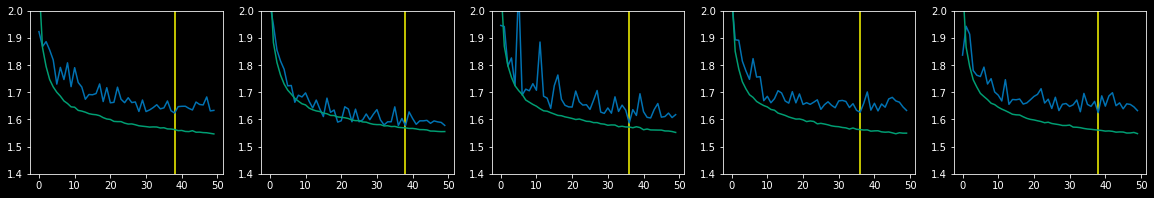

In [ ]:
#maeOverFscore
print('maeOverFscore')
plt.figure(figsize = (20,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    min_ndex = np.argmin(histories[i]['val_maeOverFscore'])
    plt.plot(histories[i]['val_maeOverFscore'])
    plt.plot(histories[i]['maeOverFscore'])
    plt.vlines(min_ndex, ymin = 0,ymax=2, colors = 'yellow')
    plt.ylim([1.4,2.0])
    print(f'Fold{i+1}')
    print('min_val_maeOverFscore : ', np.min(histories[i]['val_maeOverFscore']),' // epochs : ', np.argmin(histories[i]['val_maeOverFscore']))
plt.show()

loss


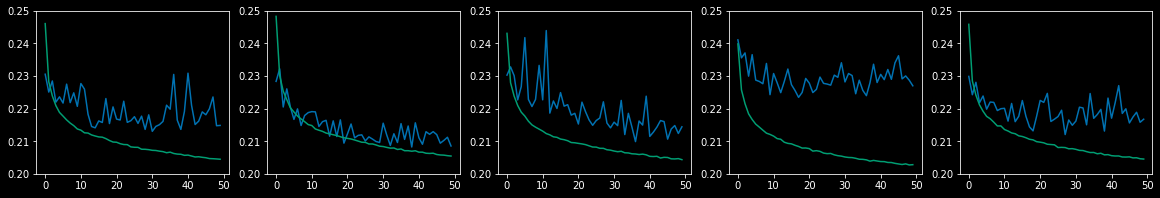

In [ ]:
# loss
print('loss')
plt.figure(figsize = (20,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(histories[i]['val_loss'])
    plt.plot(histories[i]['loss'])
    plt.ylim([0.20,0.25])
plt.show()

custom_mae


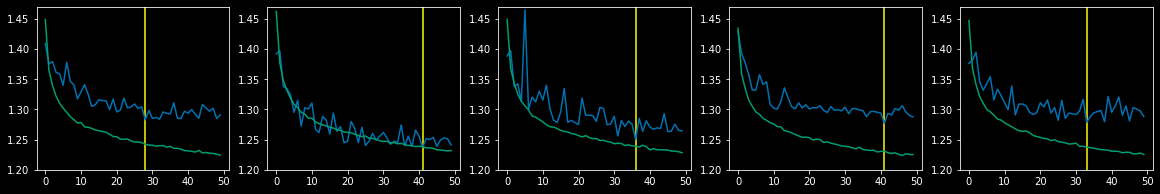

In [ ]:
# custom_mae
print('custom_mae')
plt.figure(figsize = (20,3))
for i in range(5):
    min_ndex = np.argmin(histories[i]['val_custom_mae'])
    plt.subplot(1,5,i+1)
    plt.plot(histories[i]['val_custom_mae'])
    plt.plot(histories[i]['custom_mae'])
    plt.vlines(min_ndex, ymin = 1.20,ymax=1.50, colors = 'yellow')
    plt.ylim([1.20,1.47])
plt.show()

custum_f1score


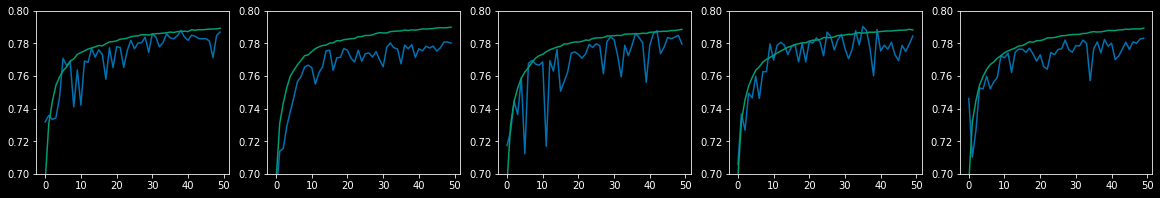

In [ ]:
# f1_metric
print('custum_f1score')
plt.figure(figsize = (20,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(histories[i]['val_custum_f1score'])
    plt.plot(histories[i]['custum_f1score'])
    plt.ylim([0.7,0.80])
plt.show()

# X. submission

In [ ]:
test = np.load('<구글 드라이브 경로>/test.npy')
# test 데이터의 land_type resize
test = preprocess(test)
test.shape

(2416, 40, 40, 14)

In [ ]:
# 5개 모델 앙상블 예측 평균 내기
preds = []
for model in models:
    model.compile(optimizer = 'adam',loss = 'mae',  metrics=[maeOverFscore, custum_f1score, custom_mae])
    preds.append(model.predict(test[:,:,:,:10]))
pred = sum(preds)/len(preds)

In [ ]:
submission = pd.read_csv('<구글 드라이브 경로>/sample_submission.csv')
submission.iloc[:,1:] = pred.reshape(-1,1600)
submission.to_csv('submission.csv', index = False)
submission

,id,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,px_10,px_11,px_12,px_13,px_14,px_15,px_16,px_17,px_18,px_19,px_20,px_21,px_22,px_23,px_24,px_25,px_26,px_27,px_28,px_29,px_30,px_31,px_32,px_33,px_34,px_35,px_36,px_37,px_38,px_39,...,px_1561,px_1562,px_1563,px_1564,px_1565,px_1566,px_1567,px_1568,px_1569,px_1570,px_1571,px_1572,px_1573,px_1574,px_1575,px_1576,px_1577,px_1578,px_1579,px_1580,px_1581,px_1582,px_1583,px_1584,px_1585,px_1586,px_1587,px_1588,px_1589,px_1590,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
0,029858_01,0.002718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.812193,0.007594,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,029858_02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.124749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,029858_03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.411885,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,029858_05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.108492,1.009329,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.404464,1.771556,5.615695,1.325815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,029858_07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.850776,1.079533,1.246665,2.031735,2.692549,2.700932,1.712599,0.851455,0.737365,1.356638,2.581905,4.777689,5.187423,3.921165,6.156259,9.966131,15.096042,19.308659,17.55603,15.192273,8.074984,5.068572,7.704577,11.672884,5.185972,1.157281,0.393779,0.290597,0.305967,0.69593,1.287479,1.795927,1.339645,0.814949,0.75365,1.548864,3.783678,3.598025,2.254057,1.101455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,031287_08,0.00